In [7]:
%matplotlib inline

import glob
import os
import random
import json

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from rubin_sim.utils import getPackageDir
#from rubin_sim.maf import KN_lc, KNePopMetric, generateKNPopSlicer, get_filename
import healpy as hp

In [9]:
import sys
import importlib

if "GRBafterglows" in sys.modules:
    del sys.modules["GRBafterglows"]

import GRBafterglows
importlib.reload(GRBafterglows)

from GRBafterglows import GRB_lc, GRBPopMetric, GRBPopMetricMultiDetect, GRBPopMetricEpochDetect, sample_grb_rate, generateGRBPopSlicer
print(GRBafterglows.__file__)


/home/andra104/Stuff/AllTransient_MetricDetection/GRBafterglows.py


Total GRB events simulated: 5004
First few peak times (days): [1057.42564972  926.5322098  1209.06875717  986.02540737 1868.25431941]
First few file indices: [52 16 63 83 60]
Generated 100 synthetic GRB light curves.
Generated 100 synthetic GRB light curves.


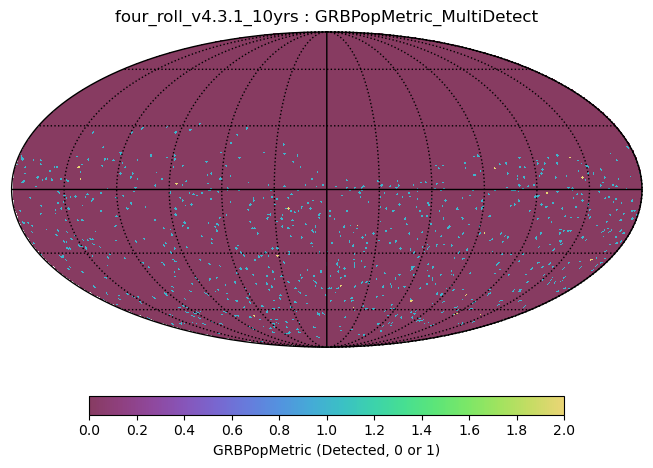

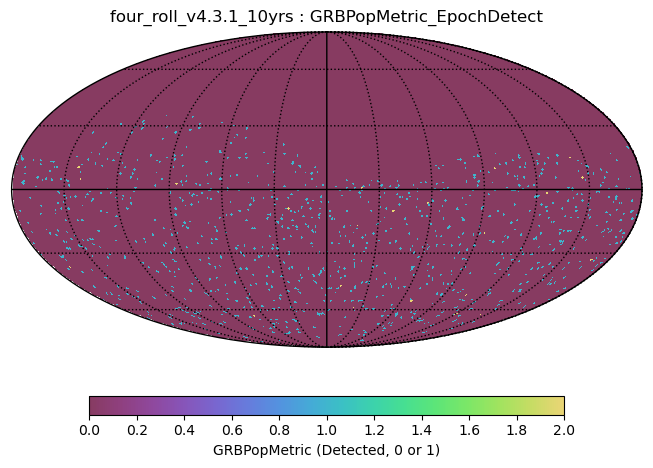

In [10]:

# GRB detection parameters
dmin = 10   # Minimum distance in Mpc
dmax = 1000 # Extend max distance for GRBs

# Number of GRB events
n_events = sample_grb_rate(1, 3652)

cadence_nickname = 'four_roll_v4.3.1_10yrs' # Used in output filenames

# Output file for GRB efficiency results
outfile = f"AllTransient_MetricDetection/efficiency_{cadence_nickname}_cadence_GRBA.csv"

# Start an output file
with open(outfile, "w") as out:
    out.write("dist_min_Mpc, dist_max_Mpc, metric, found, total, efficiency\n")

# Generate the GRB population slicer
slicer = generateGRBPopSlicer(seed=42, n_files=100, d_min=dmin, d_max=dmax)

# Load Rubin cadence database
runName = 'four_roll_v4.3.1_10yrs'
opsdb = db.OpsimDatabase(f'../AllTransient_MetricDetection/{runName}.db')

outDir = "AllTransient_MetricDetection/Metric_temp"
resultsDb = db.ResultsDb(outDir=outDir)

print(f"Total GRB events simulated: {n_events}")
print(f"First few peak times (days): {slicer.slicePoints['peak_time'][:5]}")
print(f"First few file indices: {slicer.slicePoints['file_indx'][:5]}")

# Use the updated GRBPopMetric
metric_multi = GRBPopMetricMultiDetect(outputLc=False)
metric_epoch = GRBPopMetricEpochDetect(outputLc=False)

# Configure metric bundle
sql = ''

# Define plotDict for each metric separately
plotDict_multi = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0, 'title': f'{runName} : GRBPopMetric_MultiDetect'}
plotDict_epoch = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0, 'title': f'{runName} : GRBPopMetric_EpochDetect'}

plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics = [metrics.MeanMetric(maskVal=0)]

# Define metric bundles
bundles = [
    metricBundles.MetricBundle(metric_multi, slicer, sql, runName=runName,
                               plotDict=plotDict_multi, plotFuncs=plotFuncs, summaryMetrics=summaryMetrics,
                               fileRoot=f"{runName}_GRBPopMetric_MultiDetect"),
    
    metricBundles.MetricBundle(metric_epoch, slicer, sql, runName=runName,
                               plotDict=plotDict_epoch, plotFuncs=plotFuncs, summaryMetrics=summaryMetrics,
                               fileRoot=f"{runName}_GRBPopMetric_EpochDetect"),
]

# Convert list to dictionary for MetricBundleGroup
bd = metricBundles.makeBundlesDictFromList(bundles)

# Define `bgroup` before calling `bgroup.runAll()`
bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)

bgroup.runAll()
bgroup.plotAll(closefigs=False)

# Collect results
with open(outfile, "a") as out:
    for key in bd:
        if "USER" in key:
            continue
        found = np.size(np.where(bd[key].metricValues == 1)[0])
        out.write(f"{dmin}, {dmax}, {key}, {found}, {n_events}, {found/n_events}\n")


In [11]:
print(f"Total GRB events simulated: {slicer.slicePoints['distance'].size}")


Total GRB events simulated: 4972


Generated 100 synthetic GRB light curves.


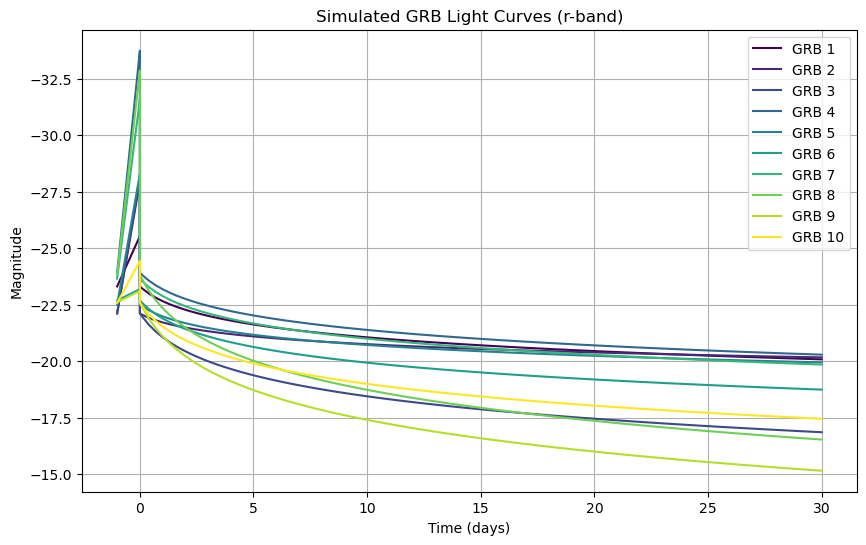

In [12]:

# Now test the light curve plot
grbs = GRBafterglows.GRB_lc(num_samples=100)
grbs.plot_light_curves(num_to_plot=10, filter_name="r")


